# Predict Housing Price in Singapore

## 1. Data exploration

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
root_dir = "."
train_data_dir = root_dir + "/datasets/train.csv"
train_data = pd.read_csv(train_data_dir)
test_data_dir = root_dir + "/datasets/test.csv"
test_data = pd.read_csv(test_data_dir)
header_data_dir = root_dir + "/datasets/hdb_data_dict.csv"
header = pd.read_csv(header_data_dir)

train_data['block'] = train_data["block"].str.extract('(\d+)',expand=False).astype(int)
test_data['block'] = test_data["block"].str.extract('(\d+)',expand=False).astype(int)

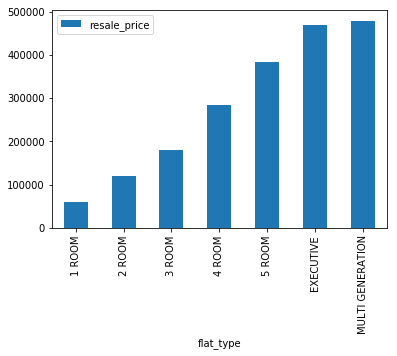

In [4]:
flat_type_pivot = train_data.pivot_table(index='flat_type',values='resale_price')
flat_type_pivot.plot.bar()
plt.show()

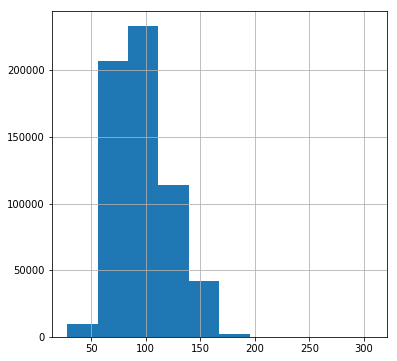

In [5]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
train_data['floor_area_sqm'].hist()

## 2. Feature engineering

Specifically:

### 2.1. Dropping features
    - Redundant ones, e.g. latitude, longitude
    - Costly to deal with, e.g. street_name
### 2.2. Extracting information from existing features
    - e.g. postal_code
### 2.3. Numerial-categorical conversion
    - e.g. month
### 2.4. Handling skewness of features
    - e.g. resale_price

In [6]:
train = train_data.drop(['index','floor','street_name','latitude','longitude'], axis=1)
test = test_data.drop(['index','floor','street_name','latitude','longitude'], axis=1)

In [7]:
from scipy.special import boxcox1p, inv_boxcox1p
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_block(df):
    cut_points = [0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    labels=label_names = ['0+','50+', '100+', '200+','300+','400+','500+','600+','700+','800+','900+']
    df["block_cat"] = pd.cut(df["block"],cut_points,labels=label_names)
    df = df.drop(['block'], axis=1)
    return df

def process_flat_type(df):
    flat_type_mapping = {'1 ROOM':1,'2 ROOM':1.978, '3 ROOM':3.002, '4 ROOM':4.736, '5 ROOM':6.403,
                         'EXECUTIVE':7.828, 'MULTI GENERATION':7.985}
    df['flat_type'] = df['flat_type'].map(flat_type_mapping)
    df['flat_type_scaled'] = df['flat_type']/8
    df = df.drop(['flat_type'], axis=1)
    return df

def process_floor_area_sqm(df):
    df['floor_area_sqm'] = boxcox1p(df['floor_area_sqm'], 0.19)
    x = boxcox1p(train_data['floor_area_sqm'], 0.19)
    y = boxcox1p(test_data['floor_area_sqm'], 0.19)
    largest = max(np.max(x), np.max(y))
    smallest = min(np.min(x), np.min(y))
    df["floor_area_sqm_scaled"] = (df['floor_area_sqm'] - smallest)/(largest - smallest)
    df = df.drop(['floor_area_sqm'], axis=1)
    return df

def process_lease_commence_date(df):
    cut_points = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
    labels=label_names = ['1960s','1970s','1980s','1990s','2000s','2010s']
    df["lease_commence_date_cat"] = pd.cut(df["lease_commence_date"],cut_points,labels=label_names)
    df = df.drop(['lease_commence_date'], axis=1)
    return df

def process_lease_commence_date_2(df):
    df["lease_commence_date"] = df["lease_commence_date"] - 1965
    deno = 2018-1965
    df["lease_commence_date_scaled"] = df['lease_commence_date']/deno
    df = df.drop(['lease_commence_date'], axis=1)
    return df

def process_month(df):
    df['month'] = df['month'].str[:4].astype(int)
    cut_points = [1989, 1993, 1996, 1999, 2002, 2005, 2008, 2011, 2014, 2017, 2020]
    labels=label_names = ['1990+','1993+', '1996+', '1999+', '2002+', '2005+', '2008+', '2011+', '2014+', '2017+']
    df["month_cat"] = pd.cut(df["month"],cut_points,labels=label_names)
    df = df.drop(['month'], axis=1)
    return df

def process_month_2(df):
    df['month'] = (pd.to_datetime(df['month']) - pd.to_datetime('1989-12'))
    deno = pd.to_datetime('2017-12') - pd.to_datetime('1989-12')
    df['month_scaled'] = df['month']/deno
    df = df.drop(['month'], axis=1)
    return df

def process_postal_code(df):
    df['postal_code'] = df['postal_code'].astype(str).str[:2]
    return df

def process_latitude(df):
    largest = max(np.max(train['latitude']), np.max(test['latitude']))
    smallest = min(np.min(train['latitude']), np.min(test['latitude']))
    df["latitude_scaled"] = (df['latitude'] - smallest)/(largest - smallest)
    df = df.drop(['latitude'], axis=1)
    return df

def process_longitude(df):
    largest = max(np.max(train['longitude']), np.max(test['longitude']))
    smallest = min(np.min(train['longitude']), np.min(test['longitude']))
    df["longitude_scaled"] = (df['longitude'] - smallest)/(largest - smallest)
    df = df.drop(['longitude'], axis=1)
    return df

def process_dummies(df):
    cols = ['flat_model','storey_range','postal_code', 'town','block_cat']
    for col in cols:
        df = create_dummies(df, col)
        df = df.drop([col], axis=1)
    return df

def process_resale_price(df):
    df['resale_price'] = boxcox1p(df['resale_price'], 0.48)
    return df

def process_train(df):
    df = process_block(df)
    df = process_flat_type(df)
    df = process_floor_area_sqm(df)
    df = process_lease_commence_date_2(df)
    df = process_postal_code(df)
    df = process_month_2(df)
    df = process_dummies(df)
    df = process_resale_price(df)
    return df

def process_test(df):
    df = process_block(df)
    df = process_flat_type(df)
    df = process_floor_area_sqm(df)
    df = process_lease_commence_date_2(df)
    df = process_postal_code(df)
    df = process_month_2(df)
    df = process_dummies(df)
    return df

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = inv_boxcox1p(y_true, 0.48), inv_boxcox1p(y_pred, 0.48)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
train_processed = process_train(train)
all_y = train_processed['resale_price']
all_X = train_processed.drop(['resale_price'], axis=1)
test_processed = process_test(test)

In [9]:
from sklearn.model_selection import train_test_split
index_array = all_X.index
X_train, X_val, y_train, y_val, train_id, val_id = train_test_split(all_X, all_y, index_array,
                                                                    test_size = 0.2, random_state = 42)

## 3. Model selection

Tried several models:
- Nearest Neighbor Regression
- Support Vector Regression
- Linear Regression
- Lasso
- Regression Tree
- Random Forest
- Xgboost
- Lightgbm

### Evaluate performance

In [10]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

mape_scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def mape_cv(model):
    mape = -cross_val_score(model, all_X, all_y, scoring=mape_scoring, cv = 5)
    return(mape)

### 3.1. Random forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=2)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_val)
mape_rf = mean_absolute_percentage_error(y_val, rf_predictions)
print("The mean-absolute-percentage-error of the random forest model is:", mape_rf)

The mean-absolute-percentage-error of the random forest model is: 5.8561962486366586


### 3.2. Lightgbm

In [14]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression')
model_lgb.fit(X_train, y_train)
lgb_predictions = model_lgb.predict(X_val)
mape_lgb = mean_absolute_percentage_error(y_val, lgb_predictions)
print("The mean-absolute-percentage-error of the XGB model is:", mape_lgb)

The mean-absolute-percentage-error of the XGB model is: 6.951962535668913


### 3.3. Combining the models

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [16]:
model_lgb = lgb.LGBMRegressor(objective='regression')
rf = RandomForestRegressor(random_state=2)
averaged_models = AveragingModels(models = (model_lgb, rf))
averaged_models.fit(X_train, y_train)
averaged_models_predictions = averaged_models.predict(X_val)
mape_avg = mean_absolute_percentage_error(y_val, averaged_models_predictions)
print("The mean-absolute-percentage-error of the stacking model is:", mape_avg)

The mean-absolute-percentage-error of the stacking model is: 5.84605305710387


## 4. Improvement

- Make use of street_name
- Get more information from longitude, latitude
- Include a meta model in the combination